## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
from tqdm import tqdm
import pandas as pd

"""
    number of trajectories in each city 
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971 
    # pittsburgh -- train: 43544 test: 6361 
    # dearborn -- train: 24465 test: 3671 
    # washington-dc -- train: 25744 test: 3829 
    # palo-alto -- train:  11993 test:1686 

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city \n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971 \n    # pittsburgh -- train: 43544 test: 6361 \n    # dearborn -- train: 24465 test: 3671 \n    # washington-dc -- train: 25744 test: 3829 \n    # palo-alto -- train:  11993 test:1686 \n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    #f_in = ROOT_PATH + split + "/" + city + "_inputs"
    f_in = split + '/' + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        #f_out = ROOT_PATH + split + "/" + city + "_outputs"
        f_out = split + '/' + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [3]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Sample a batch of data and visualize 

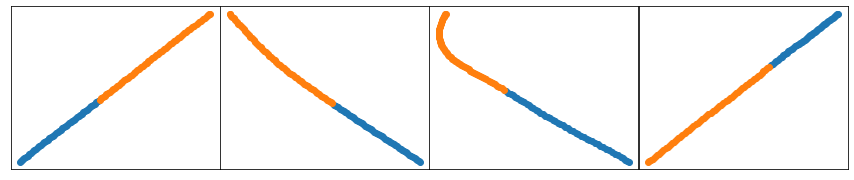

In [4]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    
    break

## 1A.

The task is to predict the path of a vehicle in the next 6 seconds given observed data for 5 seconds of its path. This is important because self-driving cars will depend on machine learning models to predict traffic patterns and appropriate paths to take. If the model is successful, then the self-driving car should be efficient and most importantly, safe; otherwise, a poor model would possibly result in dangerous decisions being made.

Input: $x_i$, the $(x, y)$ coordinates of the i-th car.

Output: $y_i$, the future $(x, y)$ coordinates of the i-th car.

Predicted Output: $\hat{y}_i = f(x_i)$ where $f(x_i)$ is a model to predict the path of the i-th car given $x_i$ input.

Loss: $\frac{1}{n} \sum_{i = 1}^{n} (y_i - \hat{y}_i)^2$

Objective: Find such an $f(x_i)$ that minimizes the loss.

In [5]:
train_city_datasets = [ArgoverseDataset(city, split = "train") for city in cities]
train_inp_datasets = []
train_out_datasets = []
for dataset in train_city_datasets:
    inp, out = dataset[:]
    train_inp_datasets.append(inp)
    train_out_datasets.append(out)

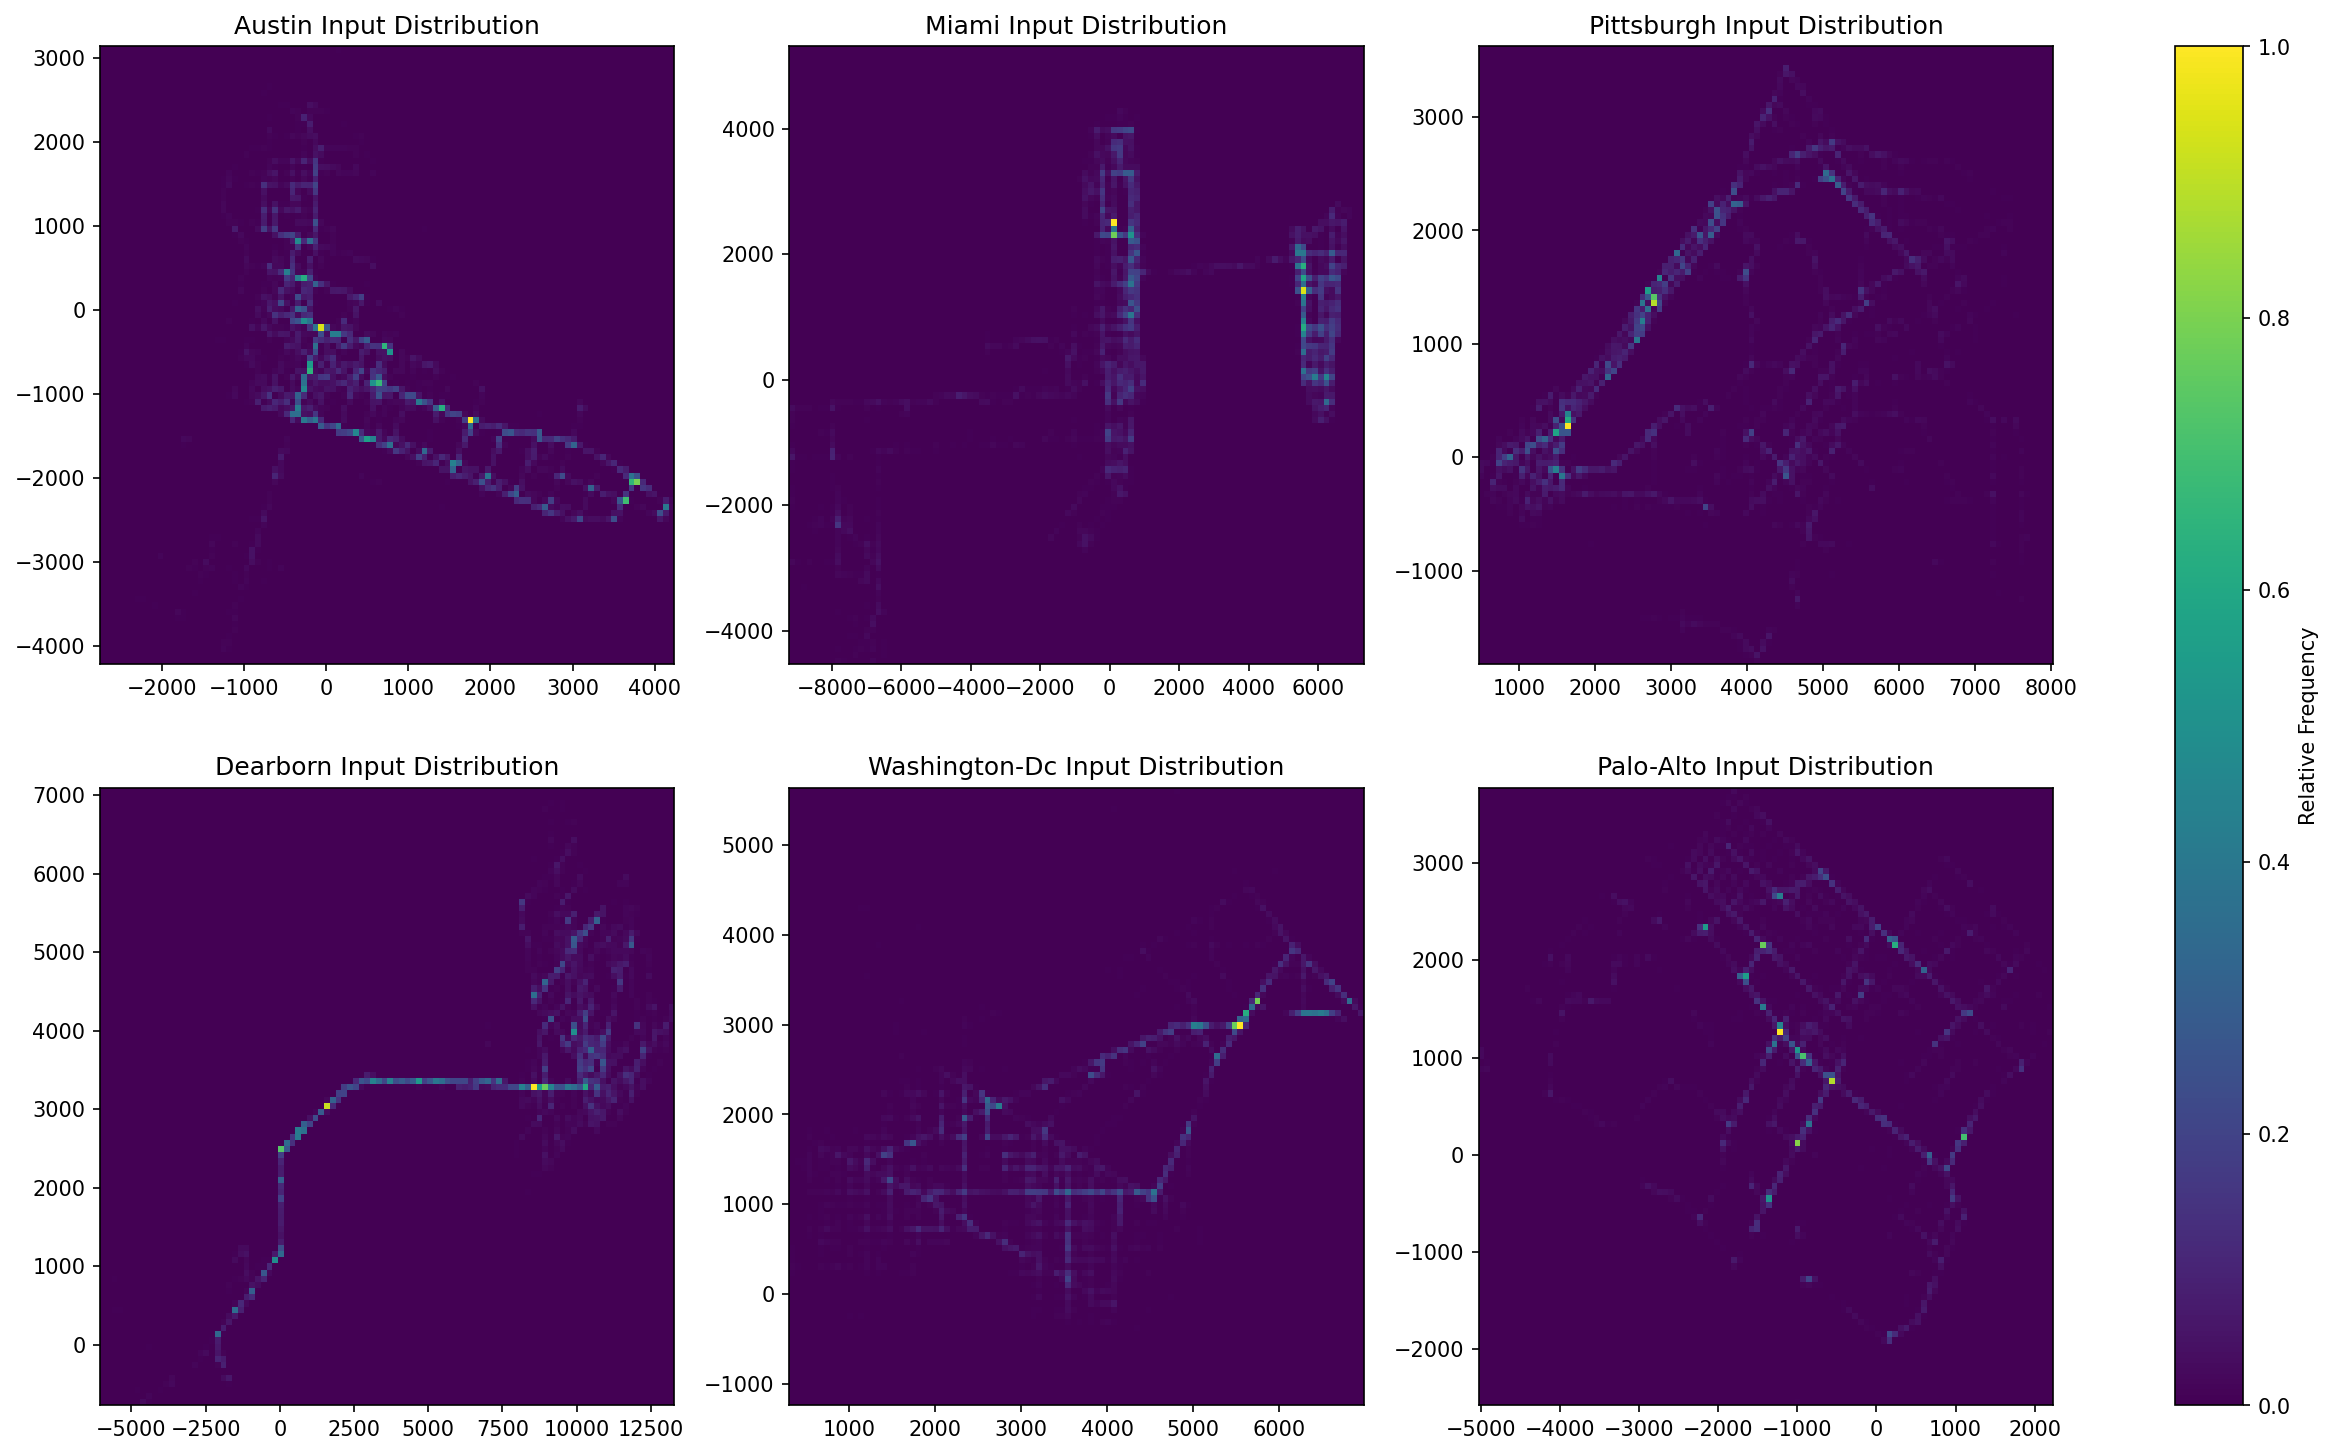

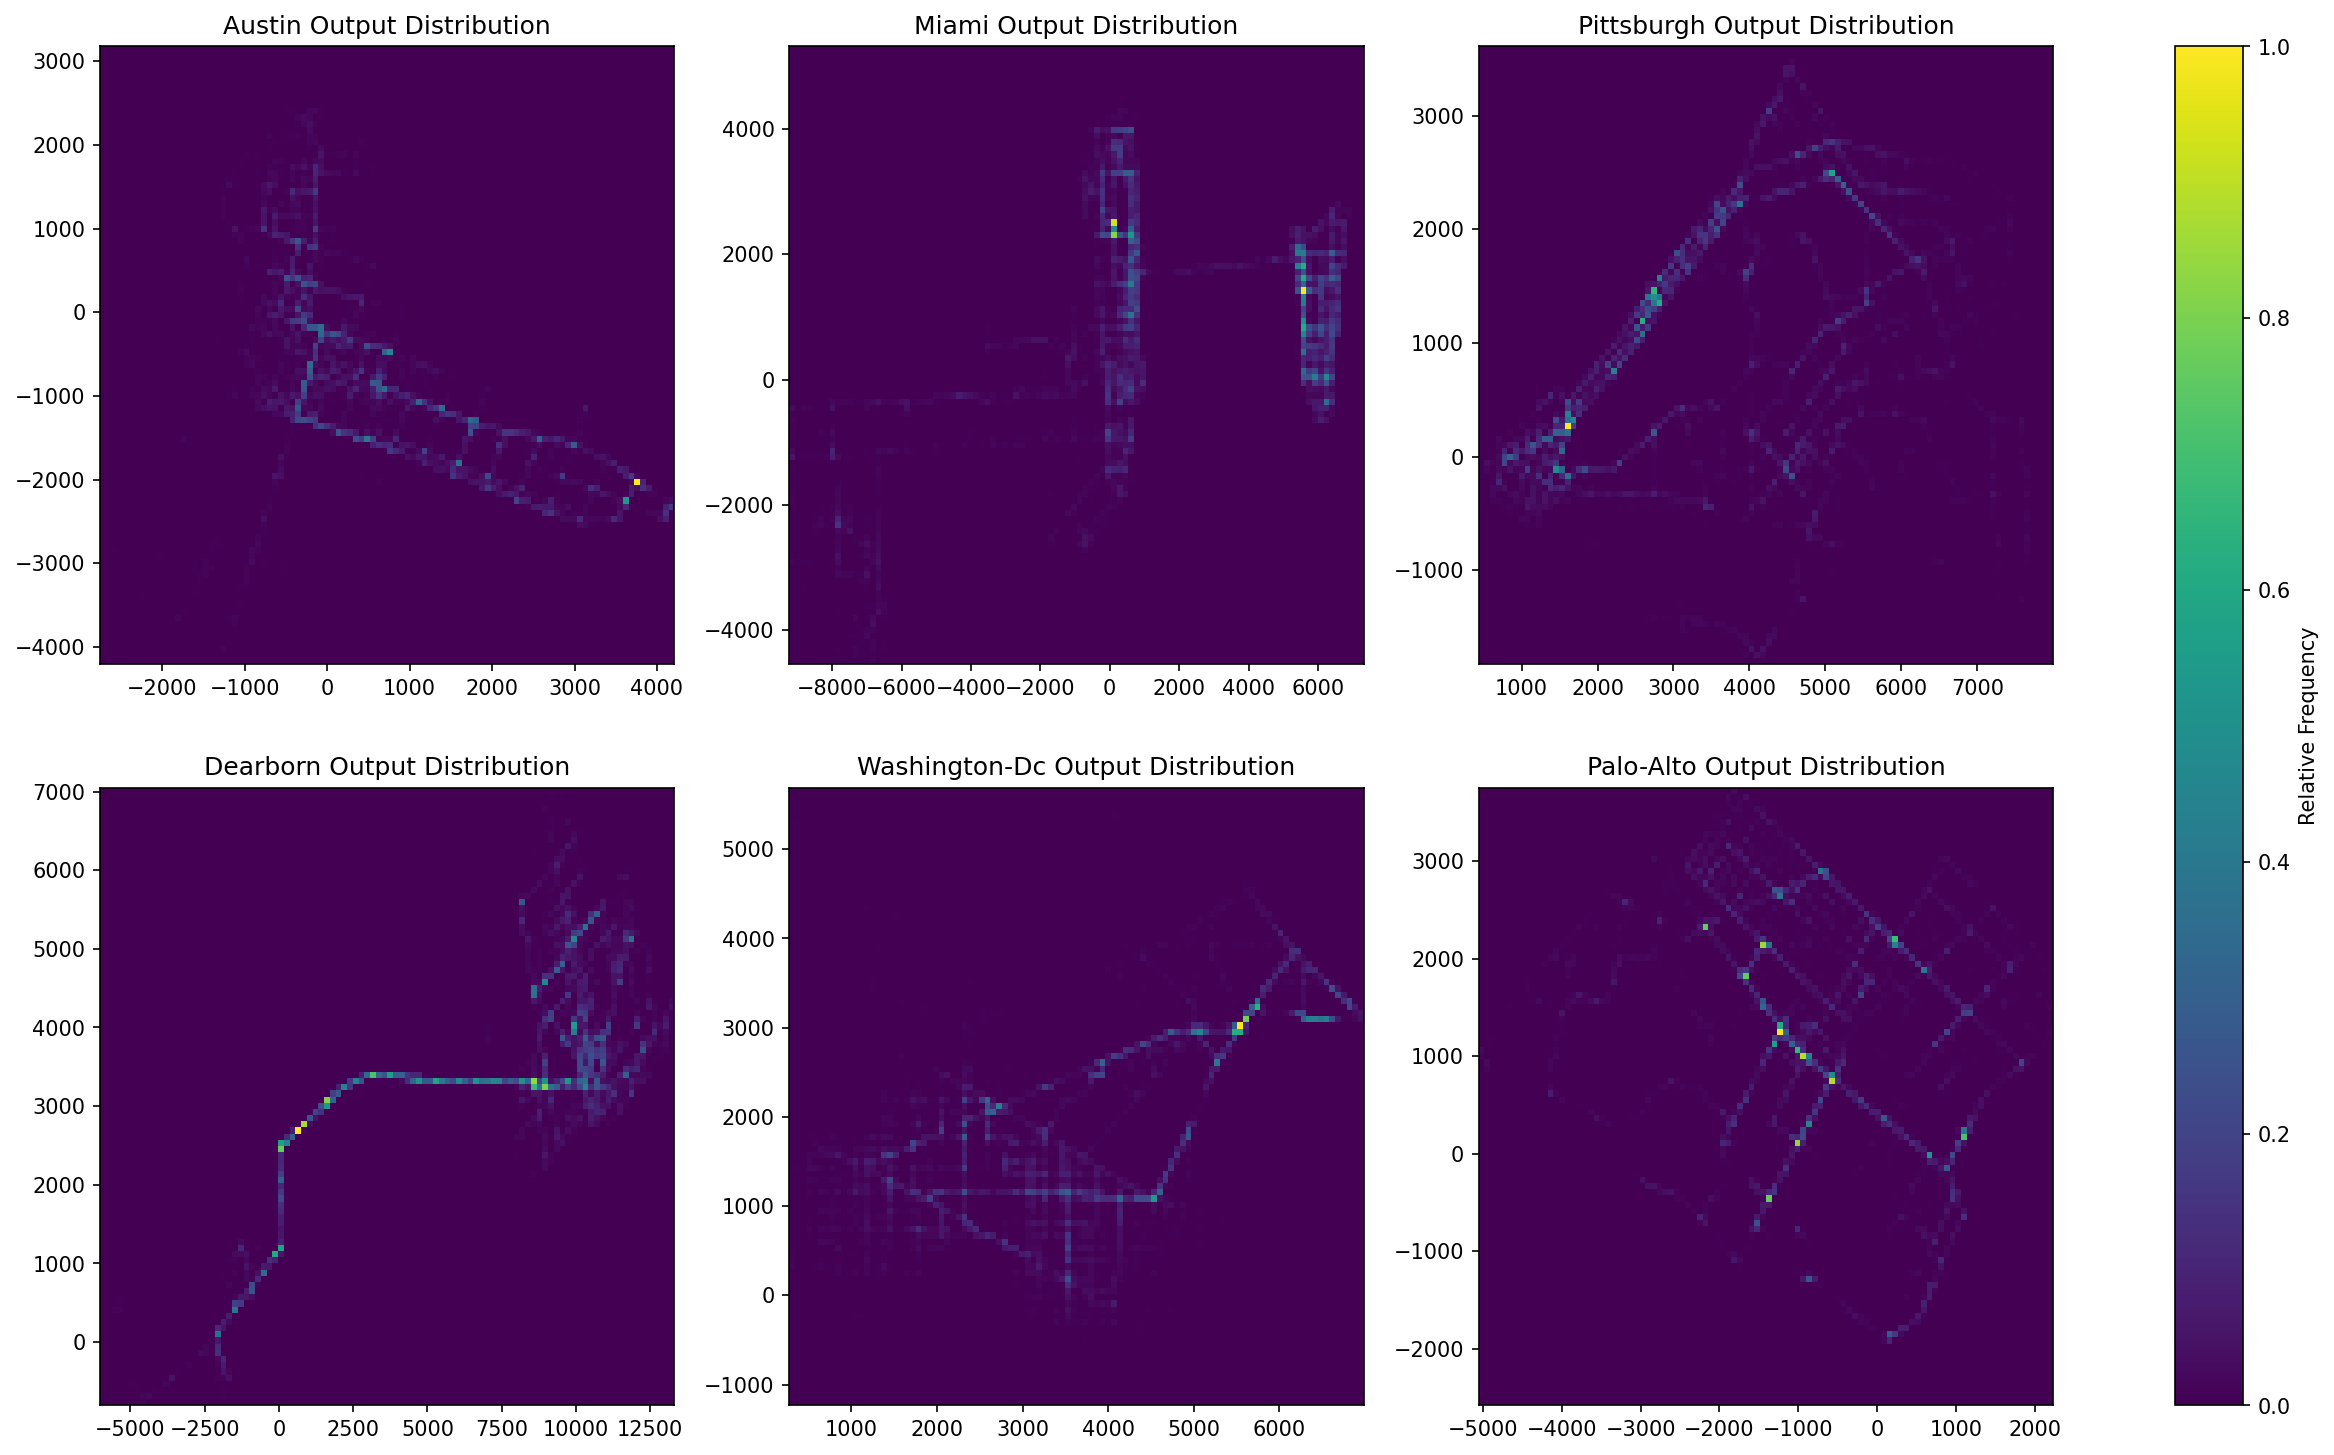

In [6]:
fig_inp, axs_inp = plt.subplots(2, int(len(cities)/2), figsize = (21, 12), dpi = 150, facecolor = "white")
fig_out, axs_out = plt.subplots(2, int(len(cities)/2), figsize = (21, 12), dpi = 150, facecolor = "white")

for i in range(len(cities)):
    city = cities[i]
    inp, out = train_inp_datasets[i], train_out_datasets[i]
    ax_inp = axs_inp.flatten()[i]
    ax_out = axs_out.flatten()[i]
    ax_inp.hist2d(inp[:,:,0].flatten(), inp[:,:,1].flatten(), bins = (100, 100))
    ax_out.hist2d(out[:,:,0].flatten(), out[:,:,1].flatten(), bins = (100, 100))
    ax_inp.set_title(city.title() + " Input Distribution")
    ax_out.set_title(city.title() + " Output Distribution")

cbar_inp = fig_inp.colorbar(mappable = ax_inp.pcolormesh([np.arange(0, 10 + 1)/10]), ax = axs_inp)
cbar_out = fig_out.colorbar(mappable = ax_out.pcolormesh([np.arange(0, 10 + 1)/10]), ax = axs_out)
cbar_inp.set_label("Relative Frequency")
cbar_out.set_label("Relative Frequency")

In [7]:
train_inp_all = np.concatenate(train_inp_datasets)
train_out_all = np.concatenate(train_out_datasets)

C:\Users\gyu12\AppData\Local\Temp/ipykernel_17472/62175863.py:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable = ax_out.pcolormesh([np.arange(0, 10 + 1)/10]));


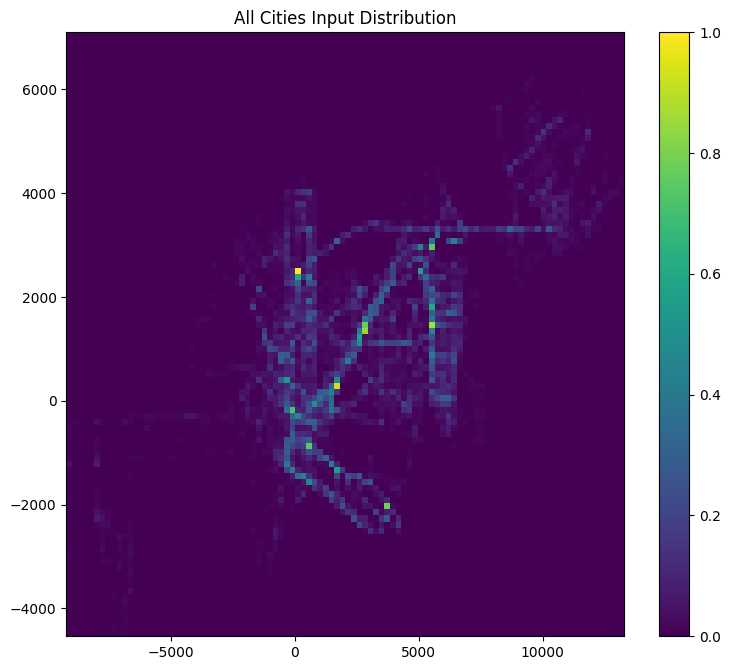

In [8]:
plt.figure(figsize = (9, 8), dpi = 100)

ax = plt.hist2d(train_inp_all[:,:,0].flatten(), train_inp_all[:,:,1].flatten(), bins = (100, 100))
plt.title("All Cities Input Distribution")
plt.colorbar(mappable = ax_out.pcolormesh([np.arange(0, 10 + 1)/10]));

C:\Users\gyu12\AppData\Local\Temp/ipykernel_17472/3357360446.py:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable = ax_out.pcolormesh([np.arange(0, 10 + 1)/10]));


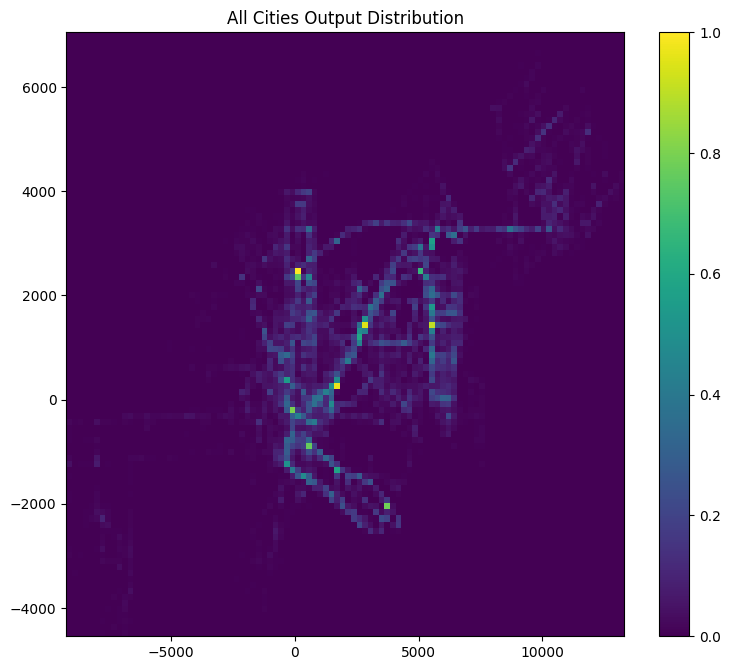

In [9]:
plt.figure(figsize = (9, 8), dpi = 100)

plt.hist2d(train_out_all[:,:,0].flatten(), train_out_all[:,:,1].flatten(), bins = (100, 100))
plt.title("All Cities Output Distribution")
plt.colorbar(mappable = ax_out.pcolormesh([np.arange(0, 10 + 1)/10]));

## 1B.

In [10]:
train_inp_all.shape

(203816, 50, 2)

In [11]:
train_out_all.shape

(203816, 60, 2)

In [12]:
test_city_datasets = [get_city_trajectories(city, split = "test")[0] for city in cities]
test_inp_all = np.concatenate(test_city_datasets)

In [13]:
test_inp_all.shape

(29843, 50, 2)

Training Data Size: 203,816 entries consisting of $(x, y)$ coordinates over 5 seconds of time with step 0.1 seconds as input and $(x, y)$ coordinates over 6 seconds of time with step 0.1 seconds as output.

Test Data Size: 29,843 entries consisting of $(x, y)$ coordinates over 5 seconds of time with step 0.1 seconds as input. No output is given, as those are the coordinates to be predicted.

(see heatmaps above)

For each different city, it seems that the positions are more focused around intersections and turns which makes sense, considering that the dataset description on Kaggle mentions how "Agents follow very complex trajectories...".

In [14]:
def make_valid_set(train_inp, train_out, train_subset = 0.8):
    if len(train_inp) != len(train_out):
        raise ValueError("Input and output lengths should be the same!")
    n = len(train_inp)
    
    split = int(n * train_subset)
    new_train_inp = train_inp[:split]
    new_train_out = train_out[:split]
    valid_inp = train_inp[split:]
    valid_out = train_out[split:]
    
    return (new_train_inp, new_train_out), (valid_inp, valid_out)

In [83]:
class LSTM(torch.nn.Module):
    """
    Implementation of a character based LSTM R-NN for the prediction task.
    """
    
    def __init__(self, train_inp, train_out, sequence_length = 1, hidden_size = 100):
        super(LSTM, self).__init__()
        self.train_input, self.train_output = train_inp, train_out
        self.train_input = torch.tensor(self.train_input).float()
        self.train_output = torch.tensor(self.train_output).float()
        if self.train_input.shape[1] % sequence_length == 0 and self.train_output.shape[1] % sequence_length == 0:
            self.sequence_length = sequence_length
        else:
            raise ValueError("Input and output lengths must be divisible by given sequence length!")
        
        input_size, output_size = self.train_input.shape[2], self.train_output.shape[2]
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers = 1)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        
        
    def forward(self, input_tensor, hidden_state):
        if len(input_tensor.shape) == 2:
            input_tensor = input_tensor.unsqueeze(dim = 0)
        output, hidden_state = self.lstm(input_tensor, hidden_state)
        output = self.fc(output)
        return output, (hidden_state[0].detach(), hidden_state[1].detach())
    
    
    def predict(self, input_tensor, output_length = 60):
        if type(input_tensor) != torch.Tensor:
            input_tensor = torch.Tensor(input_tensor)
        input_tensor = input_tensor.float()
        total_output = []
        hidden_state = None
        
        for tensor in input_tensor:
            tensor_output = []
            input_coordinates = tensor[-self.sequence_length:]
            for i in range(int(output_length / self.sequence_length)):
                output, hidden_state = self(input_coordinates, hidden_state)
                tensor_output.append(output)
                
                input_coordinates = torch.clone(output).detach()
            total_output.append(torch.cat(tensor_output).unsqueeze(dim = 0))
            
        return torch.cat(total_output)
    
    
    def evaluate(self, pred, true):
        if type(pred) != torch.Tensor:
            pred = torch.tensor(pred)
        if type(true) != torch.Tensor:
            true = torch.tensor(true)
        pred = pred.float()
        true = true.float()
        
        MSE = torch.nn.MSELoss()
        loss = MSE(pred, true).item()
        
        return loss**(1/2)
    
    
    def train(self, learning_rate = 1e-3, num_epochs = 100, batch_size = 1.0, valid = None):
        n = len(self.train_input)
        if batch_size > 1.0:
            batch_n = batch_size
        elif batch_size < 0:
            raise ValueError("Batch size cannot be negative!")
        else:
            batch_n = int(n * batch_size)
        SSE = torch.nn.MSELoss(reduction = "sum")
        optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate)
        train_loss = []
        
        if valid != None:
            valid_loss = []
            valid_inp, valid_out = valid
            old_loss = None
            new_loss = None
            bad_count = 0
        
        for epoch in tqdm(range(num_epochs)):
            epoch_SSE = 0
            np.random.seed(epoch)
            batch_idx = np.random.randint(n, size = batch_n)
            batch_inp = self.train_input[batch_idx]
            batch_out = self.train_output[batch_idx]
            
            for i in range(batch_n):
                input_tensor = batch_inp[i]
                input_coordinates = torch.unsqueeze(input_tensor[:self.sequence_length], dim = 0).float()
                output_tensor = batch_out[i]
                io_tensor = torch.cat([input_tensor, output_tensor])
                hidden_state = None

                use_output = False

                for j in range(int((len(io_tensor) - 1) / self.sequence_length)):
                    target_coordinates = torch.unsqueeze(io_tensor[(j + 1) * self.sequence_length : (j + 2) * self.sequence_length], dim = 0)

                    output, hidden_state = self(input_coordinates, hidden_state)

                    loss = SSE(output, target_coordinates)
                    epoch_SSE += loss.item()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    input_coordinates = torch.clone(output).detach()
            epoch_MSE = epoch_SSE / batch_n
            epoch_RMSE = epoch_MSE**(1/2)
            train_loss.append(epoch_RMSE)
            
            if valid != None:
                valid_pred = self.predict(valid_inp)
                valid_RMSE = self.evaluate(valid_pred, valid_out)
                valid_loss.append(valid_RMSE)
                new_loss = valid_RMSE
                if old_loss != None:
                    if new_loss >= old_loss:
                        bad_count += 1
                        if bad_count >= 3:
                            print("Early stopped after epoch ", epoch)
                            break
                    else:
                        bad_count = 0
                old_loss = new_loss
        
        if valid != None:
            return train_loss, valid_loss
        else:
            return train_loss


In [16]:
train_inp_all_subset, train_out_all_subset = train_inp_all[:int(len(train_inp_all) / 100)], train_out_all[:int(len(train_out_all) / 100)]

In [17]:
len(train_inp_all_subset)

2038

In [18]:
len(train_inp_all_subset) == len(train_out_all_subset)

True

In [19]:
train_all, valid_all = make_valid_set(train_inp_all_subset, train_out_all_subset)

In [20]:
X_train_all, y_train_all = train_all
X_valid_all, y_valid_all = valid_all

In [59]:
LSTM1 = LSTM(X_train_all, y_train_all, sequence_length = 1, hidden_size = 100)

In [ ]:
LSTM1_train_loss, LSTM1_valid_loss = LSTM1.train(batch_size = 0.25, valid = valid_all)

In [109]:
LSTM1_train_pred = LSTM1.predict(X_train_all)
LSTM1_valid_pred = LSTM1.predict(X_valid_all)

In [110]:
LSTM1_train_RMSE = LSTM1.evaluate(LSTM1_train_pred, y_train_all)
LSTM1_valid_RMSE = LSTM1.evaluate(LSTM1_valid_pred, y_valid_all)

In [111]:
LSTM1_train_RMSE

989.8404543157448

In [112]:
LSTM1_valid_RMSE

1029.7749754193874

In [126]:
torch.save(LSTM1.state_dict(), "saved_models/subset/LSTM1.pth")

In [140]:
pd.DataFrame([LSTM1_train_loss, LSTM1_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/LSTM1.csv")

In [113]:
LSTM2 = LSTM(X_train_all, y_train_all, sequence_length = 2, hidden_size = 100)

In [114]:
LSTM2_train_loss, LSTM2_valid_loss = LSTM2.train(batch_size = 0.25, valid = valid_all)

 21%|███████████████▉                                                            | 21/100 [1:05:06<4:04:54, 186.01s/it]

Early stopped after epoch  21


In [115]:
LSTM2_train_pred = LSTM2.predict(X_train_all)
LSTM2_valid_pred = LSTM2.predict(X_valid_all)

In [116]:
LSTM2_train_RMSE = LSTM2.evaluate(LSTM2_train_pred, y_train_all)
LSTM2_valid_RMSE = LSTM2.evaluate(LSTM2_valid_pred, y_valid_all)

In [119]:
LSTM2_train_RMSE

1043.1641170017306

In [120]:
LSTM2_valid_RMSE

1083.2619143125082

In [127]:
torch.save(LSTM2.state_dict(), "saved_models/subset/LSTM2.pth")

In [141]:
pd.DataFrame([LSTM2_train_loss, LSTM2_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/LSTM2.csv")

In [57]:
LSTM5 = LSTM(X_train_all, y_train_all, sequence_length = 5, hidden_size = 100)

In [58]:
LSTM5_train_loss, LSTM5_valid_loss = LSTM5.train(batch_size = 0.25, valid = valid_all)

  0%|                                                                                          | 0/100 [00:14<?, ?it/s]


RuntimeError: input must have 3 dimensions, got 2

In [144]:
LSTM5_train_pred = LSTM5.predict(X_train_all)
LSTM5_valid_pred = LSTM5.predict(X_valid_all)

In [145]:
LSTM5_train_RMSE = LSTM5.evaluate(LSTM5_train_pred, y_train_all)
LSTM5_valid_RMSE = LSTM5.evaluate(LSTM5_valid_pred, y_valid_all)

In [146]:
LSTM5_train_RMSE

971.6344477219815

In [147]:
LSTM5_valid_RMSE

1002.6100937054244

In [148]:
torch.save(LSTM5.state_dict(), "saved_models/subset/LSTM5.pth")

In [149]:
pd.DataFrame([LSTM5_train_loss, LSTM5_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/LSTM5.csv")

In [150]:
LSTM10 = LSTM(X_train_all, y_train_all, sequence_length = 10, hidden_size = 100)

In [151]:
LSTM10_train_loss, LSTM10_valid_loss = LSTM10.train(batch_size = 0.25, valid = valid_all)

  8%|██████▌                                                                           | 8/100 [03:53<44:47, 29.22s/it]

Early stopped after epoch  8


In [152]:
LSTM10_train_pred = LSTM10.predict(X_train_all)
LSTM10_valid_pred = LSTM10.predict(X_valid_all)

In [153]:
LSTM10_train_RMSE = LSTM10.evaluate(LSTM10_train_pred, y_train_all)
LSTM10_valid_RMSE = LSTM10.evaluate(LSTM10_valid_pred, y_valid_all)

In [154]:
LSTM10_train_RMSE

1152.7439546577548

In [155]:
LSTM10_valid_RMSE

1209.3046038943207

In [156]:
torch.save(LSTM5.state_dict(), "saved_models/subset/LSTM10.pth")

In [157]:
pd.DataFrame([LSTM10_train_loss, LSTM10_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/LSTM10.csv")

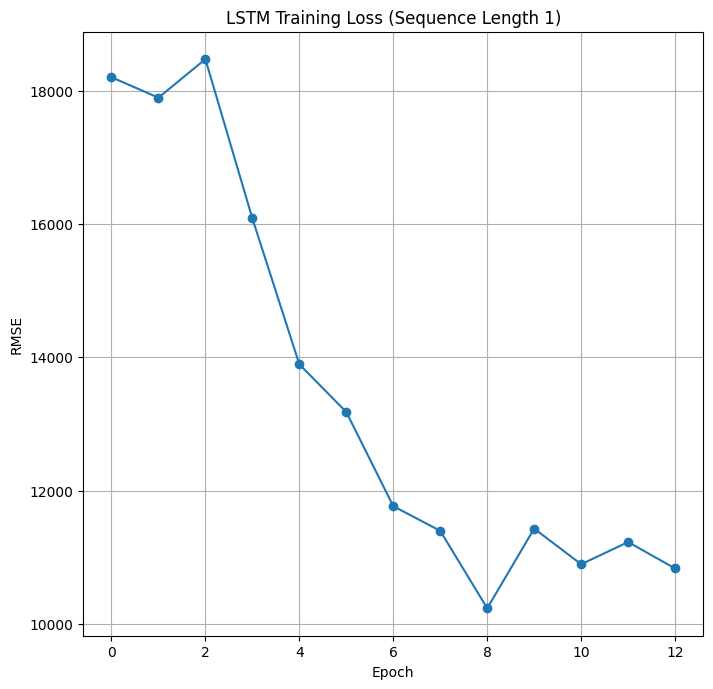

In [238]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM1_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Sequence Length 1)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()

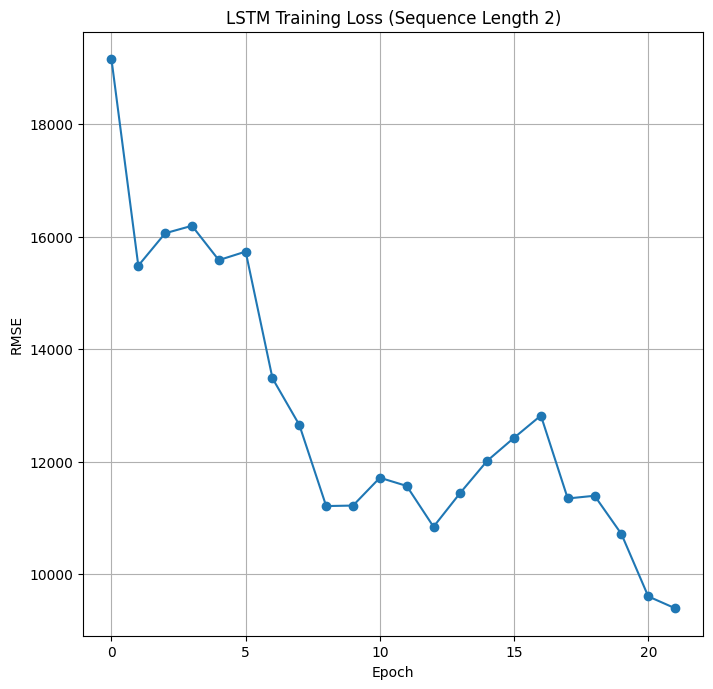

In [237]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM2_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Sequence Length 2)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()

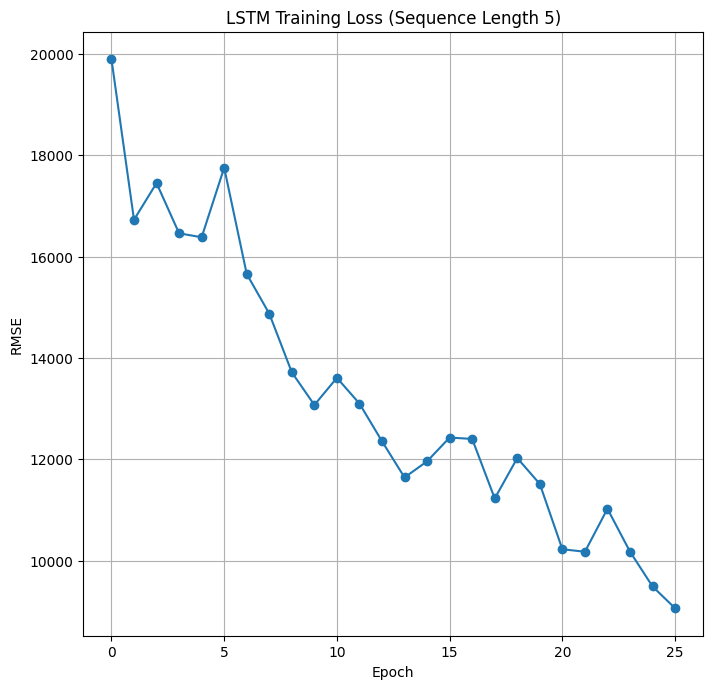

In [236]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM5_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Sequence Length 5)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()

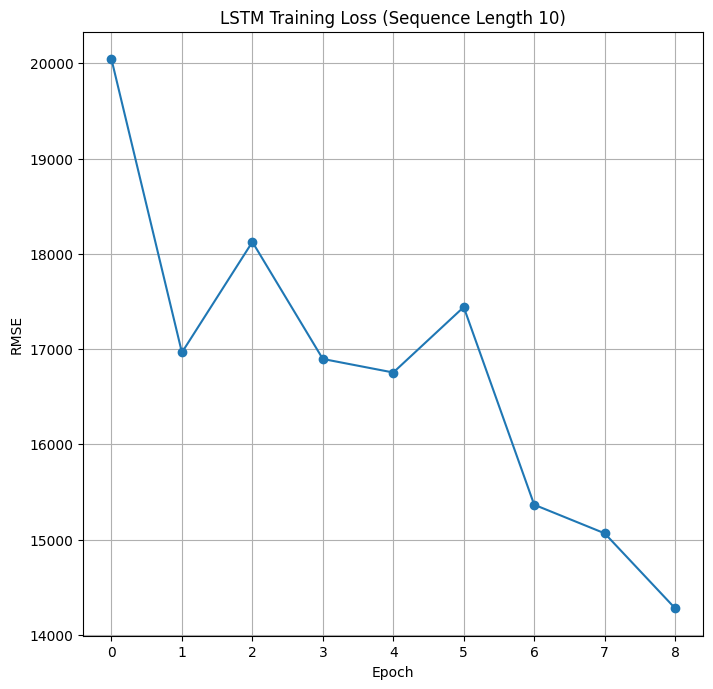

In [239]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM10_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Sequence Length 10)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()

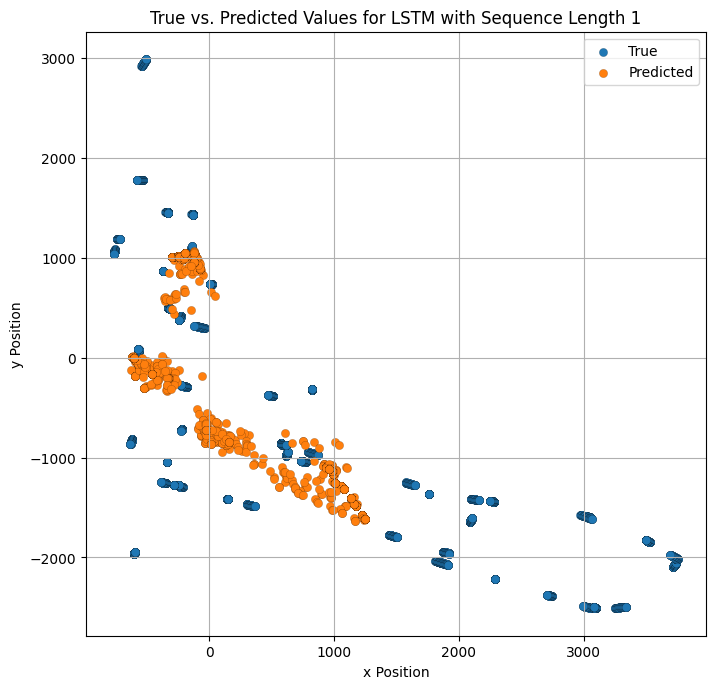

In [244]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_all[:50,:,0], y_train_all[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(LSTM1_train_pred[:50,:,0].detach(), LSTM1_train_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM with Sequence Length 1")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()

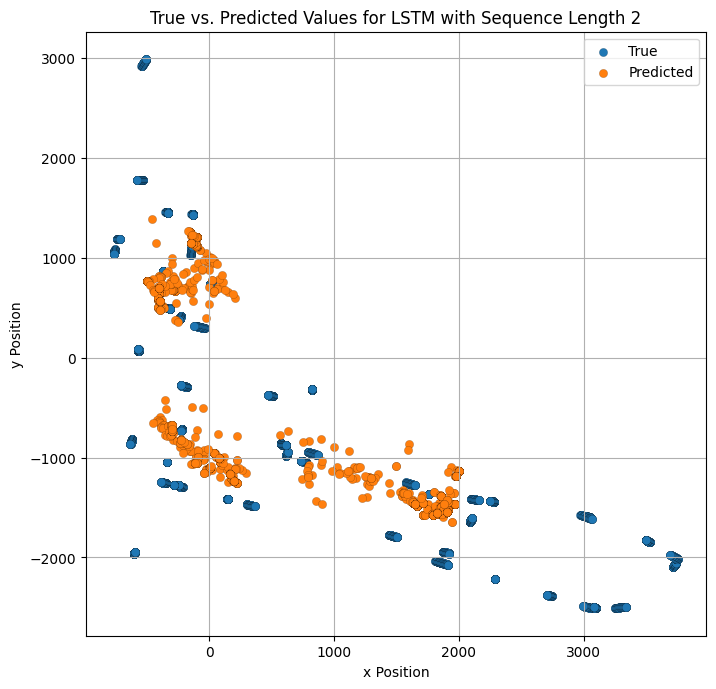

In [245]:

plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_all[:50,:,0], y_train_all[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(LSTM2_train_pred[:50,:,0].detach(), LSTM2_train_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM with Sequence Length 2")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()

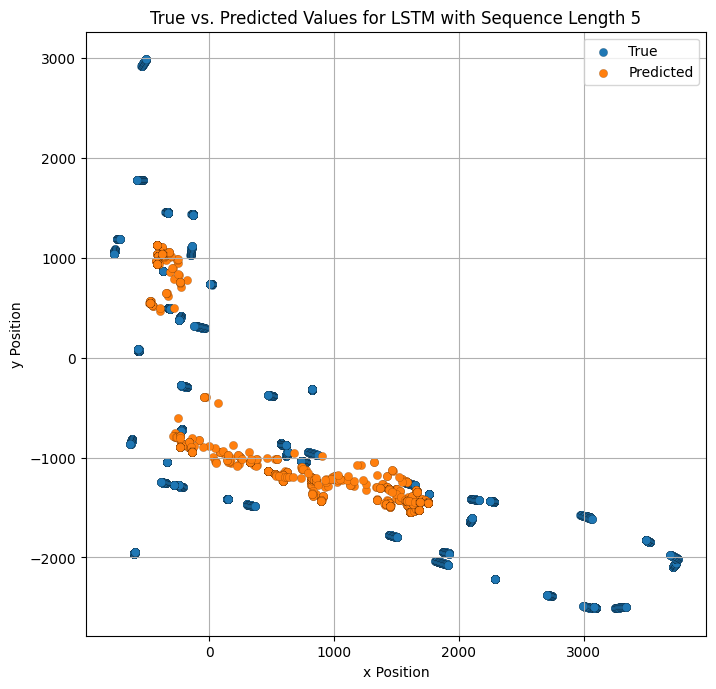

In [247]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_all[:50,:,0], y_train_all[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(LSTM5_train_pred[:50,:,0].detach(), LSTM5_train_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM with Sequence Length 5")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()

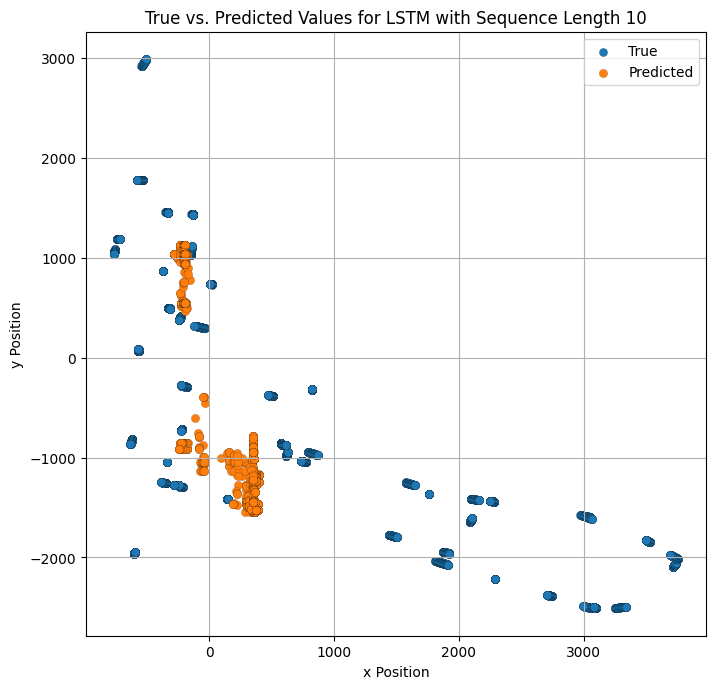

In [248]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_all[:50,:,0], y_train_all[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(LSTM10_train_pred[:50,:,0].detach(), LSTM5_train_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM with Sequence Length 10")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()

In [251]:
pd.DataFrame(
    [LSTM1_train_loss, LSTM2_train_loss, LSTM5_train_loss, LSTM10_train_loss]
).T.rename(columns = {0: 1, 1: 2, 2: 5, 3: 10})

,1,2,5,10
0,18206.288519,19152.462986,19896.676146,20042.965743
1,17899.155824,15484.062576,16727.846862,16964.391091
2,18477.480870,16059.878644,17452.115001,18124.723379
3,16086.556305,16192.760419,16460.409989,16896.477600
4,13895.350045,15582.746597,16382.325921,16754.203461
5,13179.222567,15734.290535,17755.243284,17441.192005
6,11764.969060,13482.320056,15657.218516,15366.565253
7,11394.945329,12654.852810,14874.944366,15066.406397
8,10232.260292,11213.590481,13717.518942,14279.707391
9,11428.295638,11222.516132,13073.308107,NaN


In [436]:
pd.DataFrame(
    [LSTM1_train_RMSE, LSTM2_train_RMSE, LSTM5_train_RMSE, LSTM10_train_RMSE],
    index = [1, 2, 5, 10],
    columns = ["Final Train RMSE"]
)

,Final Train RMSE
1,989.840454
2,1043.164117
5,971.634448
10,1152.743955


In [352]:
train_austin = train_city_datasets[0][:]
train_inp_austin, train_out_austin = train_austin

train_miami = train_city_datasets[1][:]
train_inp_miami, train_out_miami = train_miami

train_pittsburgh = train_city_datasets[2][:]
train_inp_pittsburgh, train_out_pittsburgh = train_pittsburgh

train_dearborn = train_city_datasets[3][:]
train_inp_dearborn, train_out_dearborn = train_dearborn

train_dc = train_city_datasets[4][:]
train_inp_dc, train_out_dc = train_dc

train_palo_alto = train_city_datasets[5][:]
train_inp_palo_alto, train_out_palo_alto = train_palo_alto

In [353]:
train_inp_austin_subset = train_inp_austin[:int(len(train_inp_austin) / 25)]
train_out_austin_subset = train_out_austin[:int(len(train_out_austin) / 25)]

train_inp_miami_subset = train_inp_miami[:int(len(train_inp_miami) / 25)]
train_out_miami_subset = train_out_miami[:int(len(train_out_miami) / 25)]

train_inp_pittsburgh_subset = train_inp_pittsburgh[:int(len(train_inp_pittsburgh) / 25)]
train_out_pittsburgh_subset = train_out_pittsburgh[:int(len(train_out_pittsburgh) / 25)]

train_inp_dearborn_subset = train_inp_dearborn[:int(len(train_inp_dearborn) / 15)]
train_out_dearborn_subset = train_out_dearborn[:int(len(train_out_dearborn) / 15)]

train_inp_dc_subset = train_inp_dc[:int(len(train_inp_dc) / 15)]
train_out_dc_subset = train_out_dc[:int(len(train_out_dc) / 15)]

train_inp_palo_alto_subset = train_inp_palo_alto[:int(len(train_inp_palo_alto) / 5)]
train_out_palo_alto_subset = train_out_palo_alto[:int(len(train_out_palo_alto) / 5)]

In [354]:
len(train_inp_austin_subset), len(train_inp_austin_subset) == len(train_out_austin_subset)

(1721, True)

In [355]:
len(train_inp_miami_subset), len(train_inp_miami_subset) == len(train_out_miami_subset)

(2201, True)

In [356]:
len(train_inp_pittsburgh_subset), len(train_inp_pittsburgh_subset) == len(train_out_pittsburgh_subset)

(1741, True)

In [357]:
len(train_inp_dearborn_subset), len(train_inp_dearborn_subset) == len(train_out_dearborn_subset)

(1631, True)

In [358]:
len(train_inp_dc_subset), len(train_inp_dc_subset) == len(train_out_dc_subset)

(1716, True)

In [359]:
len(train_inp_palo_alto_subset), len(train_inp_palo_alto_subset) == len(train_out_palo_alto_subset)

(2398, True)

In [360]:
new_train_austin, valid_austin = make_valid_set(train_inp_austin_subset, train_out_austin_subset)
X_train_austin, y_train_austin = new_train_austin
X_valid_austin, y_valid_austin = valid_austin

In [361]:
new_train_miami, valid_miami = make_valid_set(train_inp_miami_subset, train_out_miami_subset)
X_train_miami, y_train_miami = new_train_miami
X_valid_miami, y_valid_miami = valid_miami

In [362]:
new_train_pittsburgh, valid_pittsburgh = make_valid_set(train_inp_pittsburgh_subset, train_out_pittsburgh_subset)
X_train_pittsburgh, y_train_pittsburgh = new_train_pittsburgh
X_valid_pittsburgh, y_valid_pittsburgh = valid_miami

In [364]:
new_train_dearborn, valid_dearborn = make_valid_set(train_inp_dearborn_subset, train_out_dearborn_subset)
X_train_dearborn, y_train_dearborn = new_train_dearborn
X_valid_dearborn, y_valid_dearborn = valid_dearborn

In [365]:
new_train_dc, valid_dc = make_valid_set(train_inp_dc_subset, train_out_dc_subset)
X_train_dc, y_train_dc = new_train_dc
X_valid_dc, y_valid_dc = valid_dc

In [366]:
new_train_palo_alto, valid_palo_alto = make_valid_set(train_inp_palo_alto_subset, train_out_palo_alto_subset)
X_train_palo_alto, y_train_palo_alto = new_train_palo_alto
X_valid_palo_alto, y_valid_palo_alto = valid_palo_alto

In [367]:
LSTM_Austin = LSTM(X_train_austin, y_train_austin, sequence_length = 5, hidden_size = 100)
LSTM_Miami = LSTM(X_train_miami, y_train_miami, sequence_length = 5, hidden_size = 100)
LSTM_Pittsburgh = LSTM(X_train_pittsburgh, y_train_pittsburgh, sequence_length = 5, hidden_size = 100)
LSTM_Dearborn = LSTM(X_train_dearborn, y_train_dearborn, sequence_length = 5, hidden_size = 100)
LSTM_DC = LSTM(X_train_dc, y_train_dc, sequence_length = 5, hidden_size = 100)
LSTM_Palo_Alto = LSTM(X_train_palo_alto, y_train_palo_alto, sequence_length = 5, hidden_size = 100)

In [368]:
LSTM_Austin_train_loss, LSTM_Austin_valid_loss = LSTM_Austin.train(batch_size = 0.25, valid = valid_austin)

 39%|███████████████████████████████▌                                                 | 39/100 [28:02<43:51, 43.13s/it]

Early stopped after epoch  39


In [369]:
y_train_austin_pred = LSTM_Austin.predict(X_train_austin)
y_valid_austin_pred = LSTM_Austin.predict(X_valid_austin)

In [370]:
y_train_austin_RMSE = LSTM_Austin.evaluate(y_train_austin_pred, y_train_austin)
y_valid_austin_RMSE = LSTM_Austin.evaluate(y_valid_austin_pred, y_valid_austin)

In [371]:
y_train_austin_RMSE

1026.1623287764953

In [372]:
y_valid_austin_RMSE

1008.6444802307699

In [373]:
torch.save(LSTM_Austin.state_dict(), "saved_models/subset/cities/LSTM_Austin.pth")

In [375]:
pd.DataFrame([LSTM_Austin_train_loss, LSTM_Austin_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_Austin.csv")

In [376]:
LSTM_Miami_train_loss, LSTM_Miami_valid_loss = LSTM_Miami.train(batch_size = 0.25, valid = valid_miami)

 42%|██████████████████████████████████                                               | 42/100 [36:43<50:42, 52.46s/it]

Early stopped after epoch  42


In [379]:
y_train_miami_pred = LSTM_Miami.predict(X_train_miami)
y_valid_miami_pred = LSTM_Miami.predict(X_valid_miami)

In [380]:
y_train_miami_RMSE = LSTM_Miami.evaluate(y_train_miami_pred, y_train_miami)
y_valid_miami_RMSE = LSTM_Miami.evaluate(y_valid_miami_pred, y_valid_miami)

In [381]:
y_train_miami_RMSE

2521.6350846226737

In [382]:
y_valid_miami_RMSE

2486.488990524591

In [383]:
torch.save(LSTM_Miami.state_dict(), "saved_models/subset/cities/LSTM_Miami.pth")

In [384]:
pd.DataFrame([LSTM_Miami_train_loss, LSTM_Miami_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_Miami.csv")

In [385]:
LSTM_Pittsburgh_train_loss, LSTM_Pittsburgh_valid_loss = LSTM_Pittsburgh.train(batch_size = 0.25, valid = valid_pittsburgh)

 23%|██████████████████▏                                                            | 23/100 [21:49<1:13:04, 56.94s/it]

Early stopped after epoch  23


In [386]:
y_train_pittsburgh_pred = LSTM_Pittsburgh.predict(X_train_pittsburgh)
y_valid_pittsburgh_pred = LSTM_Pittsburgh.predict(X_valid_pittsburgh)

In [387]:
y_train_pittsburgh_RMSE = LSTM_Pittsburgh.evaluate(y_train_pittsburgh_pred, y_train_pittsburgh)
y_valid_pittsburgh_RMSE = LSTM_Pittsburgh.evaluate(y_valid_pittsburgh_pred, y_valid_pittsburgh)

In [388]:
y_train_pittsburgh_RMSE

1364.3597857603397

In [389]:
y_valid_pittsburgh_RMSE

3022.3752248852225

In [390]:
torch.save(LSTM_Pittsburgh.state_dict(), "saved_models/subset/cities/LSTM_Pittsburgh.pth")

In [391]:
pd.DataFrame([LSTM_Pittsburgh_train_loss, LSTM_Pittsburgh_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_Pittsburgh.csv")

In [392]:
LSTM_Dearborn_train_loss, LSTM_Dearborn_valid_loss = LSTM_Dearborn.train(batch_size = 0.25, valid = valid_dearborn)

 35%|███████████████████████████▋                                                   | 35/100 [42:33<1:19:03, 72.97s/it]

Early stopped after epoch  35


In [393]:
y_train_dearborn_pred = LSTM_Dearborn.predict(X_train_dearborn)
y_valid_dearborn_pred = LSTM_Dearborn.predict(X_valid_dearborn)

In [394]:
y_train_dearborn_RMSE = LSTM_Dearborn.evaluate(y_train_dearborn_pred, y_train_dearborn)
y_valid_dearborn_RMSE = LSTM_Dearborn.evaluate(y_valid_dearborn_pred, y_valid_dearborn)

In [395]:
y_train_dearborn_RMSE

3190.5681312267884

In [396]:
y_valid_dearborn_RMSE

3168.101008490733

In [397]:
torch.save(LSTM_Dearborn.state_dict(), "saved_models/subset/cities/LSTM_Dearborn.pth")

In [398]:
pd.DataFrame([LSTM_Dearborn_train_loss, LSTM_Dearborn_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_Dearborn.csv")

In [399]:
LSTM_DC_train_loss, LSTM_DC_valid_loss = LSTM_DC.train(batch_size = 0.25, valid = valid_dc)

 36%|████████████████████████████▍                                                  | 36/100 [52:41<1:33:39, 87.81s/it]

Early stopped after epoch  36


In [400]:
y_train_dc_pred = LSTM_DC.predict(X_train_dc)
y_valid_dc_pred = LSTM_DC.predict(X_valid_dc)

In [401]:
y_train_dc_RMSE = LSTM_DC.evaluate(y_train_dc_pred, y_train_dc)
y_valid_dc_RMSE = LSTM_DC.evaluate(y_valid_dc_pred, y_valid_dc)

In [402]:
y_train_dc_RMSE

1329.1880040084623

In [403]:
y_valid_dc_RMSE

1317.0290429599493

In [404]:
torch.save(LSTM_DC.state_dict(), "saved_models/subset/cities/LSTM_DC.pth")

In [405]:
pd.DataFrame([LSTM_DC_train_loss, LSTM_DC_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_DC.csv")

In [406]:
LSTM_Palo_Alto_train_loss, LSTM_Palo_Alto_valid_loss = LSTM_Palo_Alto.train(batch_size = 0.25, valid = valid_palo_alto)

 10%|███████▊                                                                      | 10/100 [17:37<2:38:41, 105.79s/it]

Early stopped after epoch  10


In [407]:
y_train_palo_alto_pred = LSTM_Palo_Alto.predict(X_train_palo_alto)
y_valid_palo_alto_pred = LSTM_Palo_Alto.predict(X_valid_palo_alto)

In [408]:
y_train_palo_alto_RMSE = LSTM_Palo_Alto.evaluate(y_train_palo_alto_pred, y_train_palo_alto)
y_valid_palo_alto_RMSE = LSTM_Palo_Alto.evaluate(y_valid_palo_alto_pred, y_valid_palo_alto)

In [409]:
y_train_palo_alto_RMSE

1082.2736483902765

In [410]:
y_valid_palo_alto_RMSE

1096.1865717112212

In [411]:
torch.save(LSTM_Palo_Alto.state_dict(), "saved_models/subset/cities/LSTM_Palo_Alto.pth")

In [412]:
pd.DataFrame([LSTM_Palo_Alto_train_loss, LSTM_Palo_Alto_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_Palo_Alto.csv")

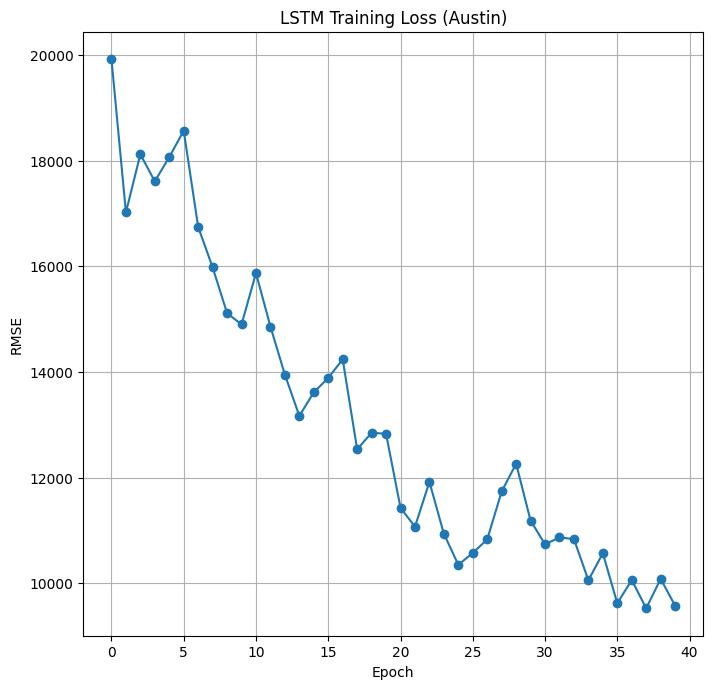

In [413]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_Austin_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Austin)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()

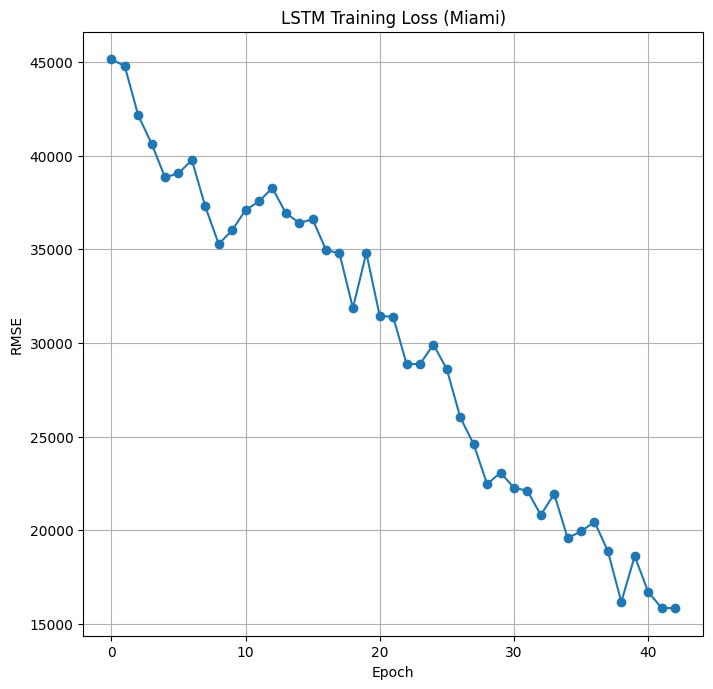

In [414]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_Miami_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Miami)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()

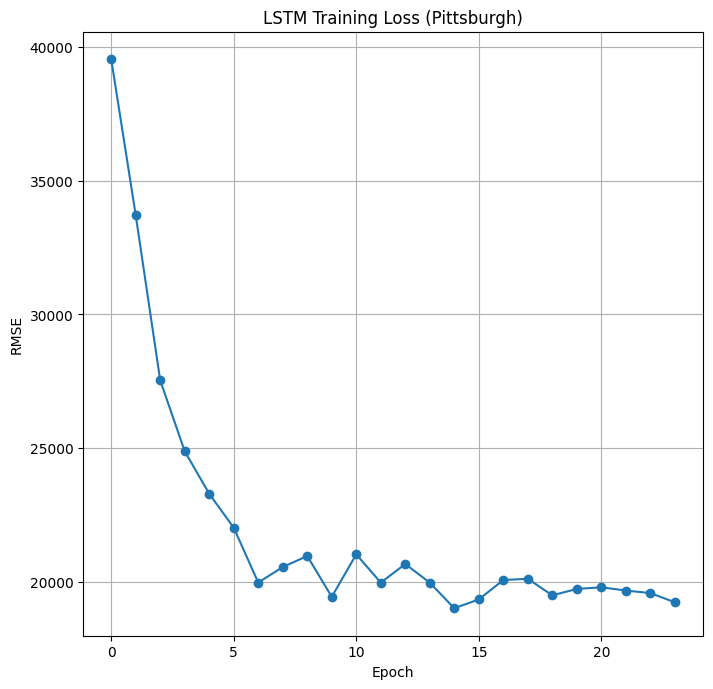

In [415]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_Pittsburgh_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Pittsburgh)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()

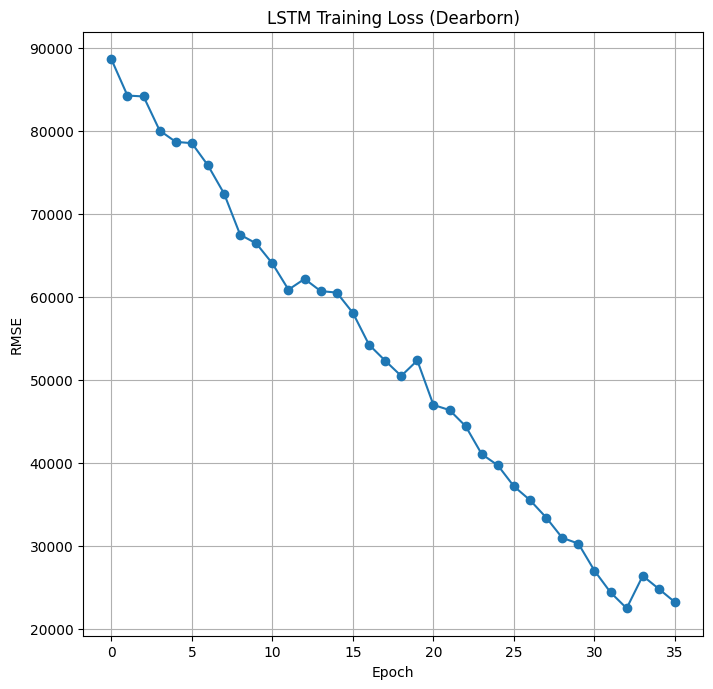

In [416]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_Dearborn_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Dearborn)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()

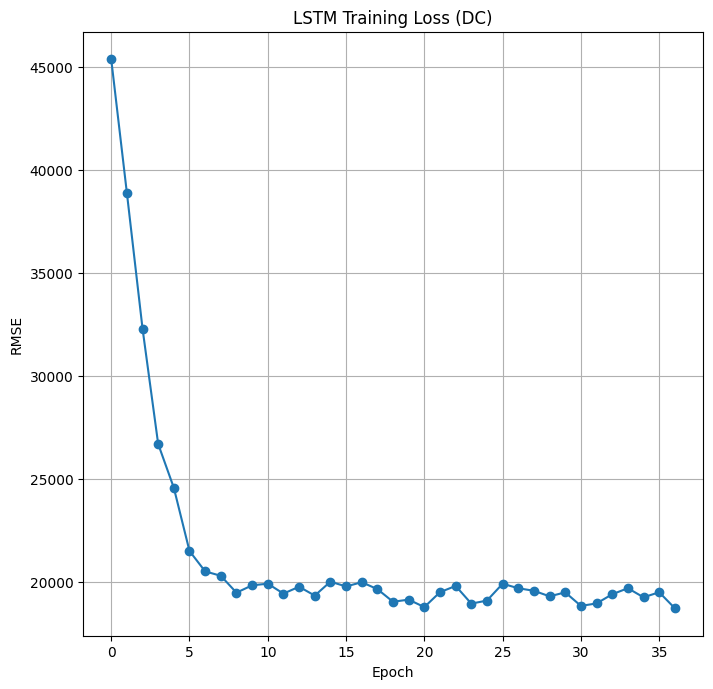

In [417]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_DC_train_loss, marker = 'o')
plt.title("LSTM Training Loss (DC)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()

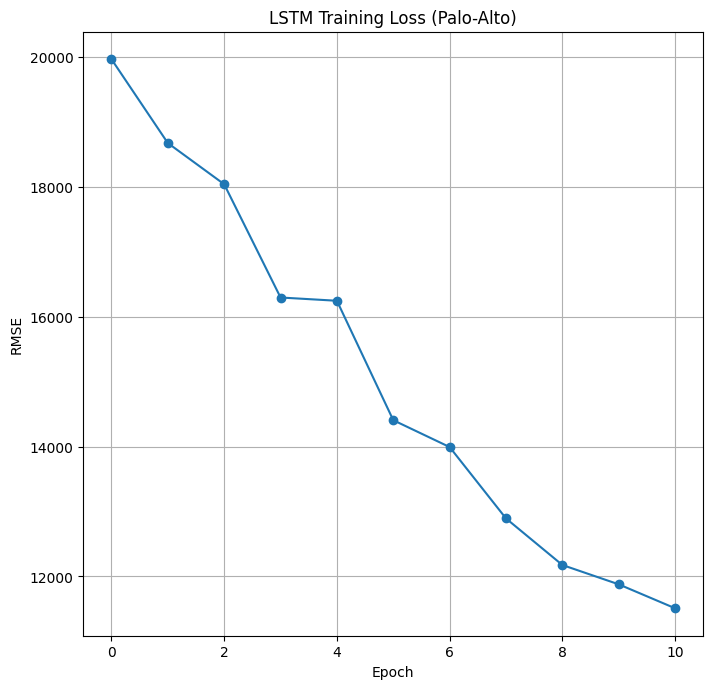

In [418]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_Palo_Alto_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Palo-Alto)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()

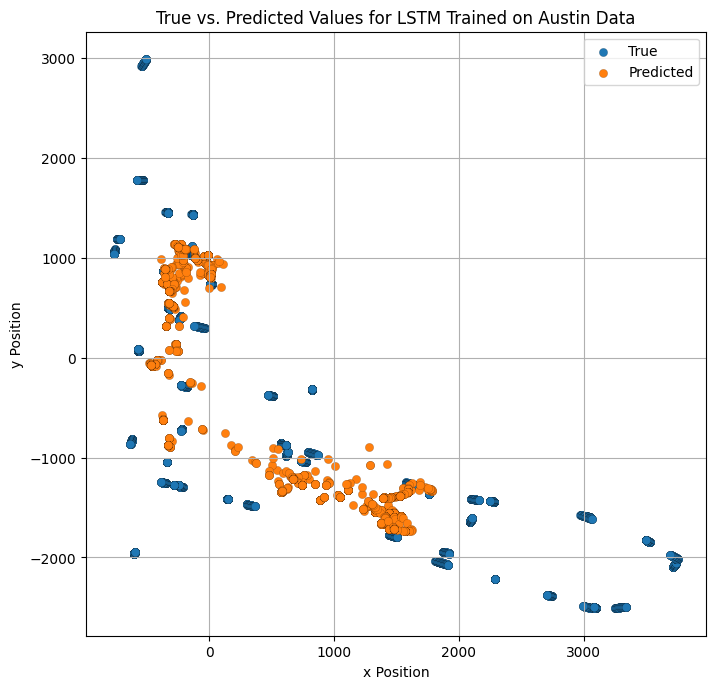

In [419]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_austin[:50,:,0], y_train_austin[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_austin_pred[:50,:,0].detach(), y_train_austin_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on Austin Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()

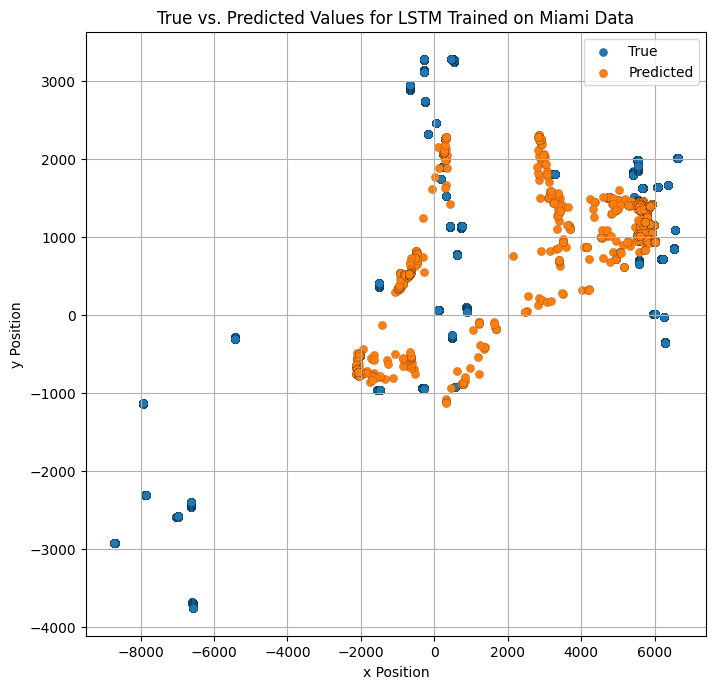

In [420]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_miami[:50,:,0], y_train_miami[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_miami_pred[:50,:,0].detach(), y_train_miami_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on Miami Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()

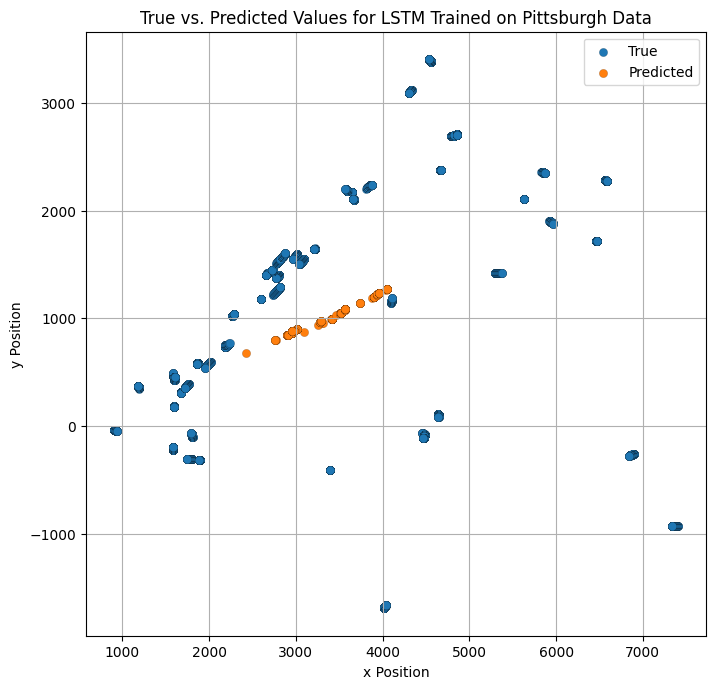

In [421]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_pittsburgh[:50,:,0], y_train_pittsburgh[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_pittsburgh_pred[:50,:,0].detach(), y_train_pittsburgh_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on Pittsburgh Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()

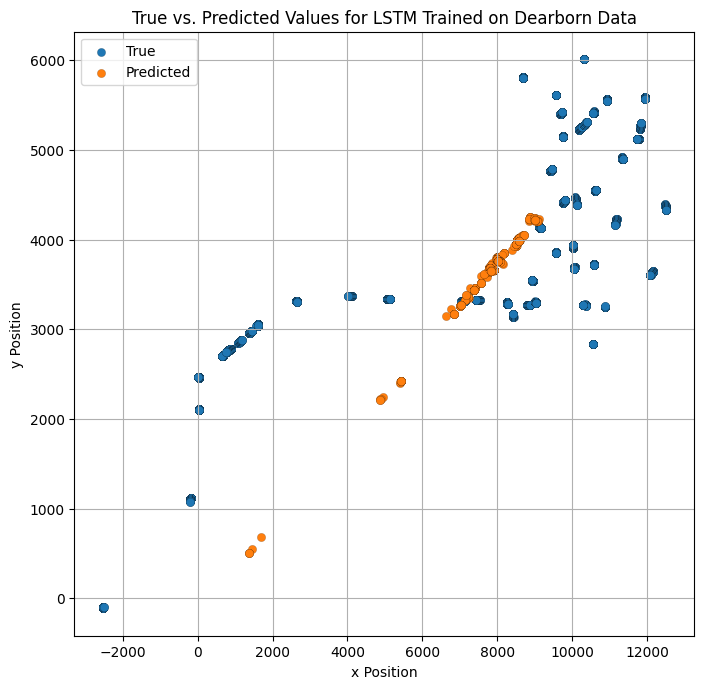

In [422]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_dearborn[:50,:,0], y_train_dearborn[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_dearborn_pred[:50,:,0].detach(), y_train_dearborn_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on Dearborn Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()

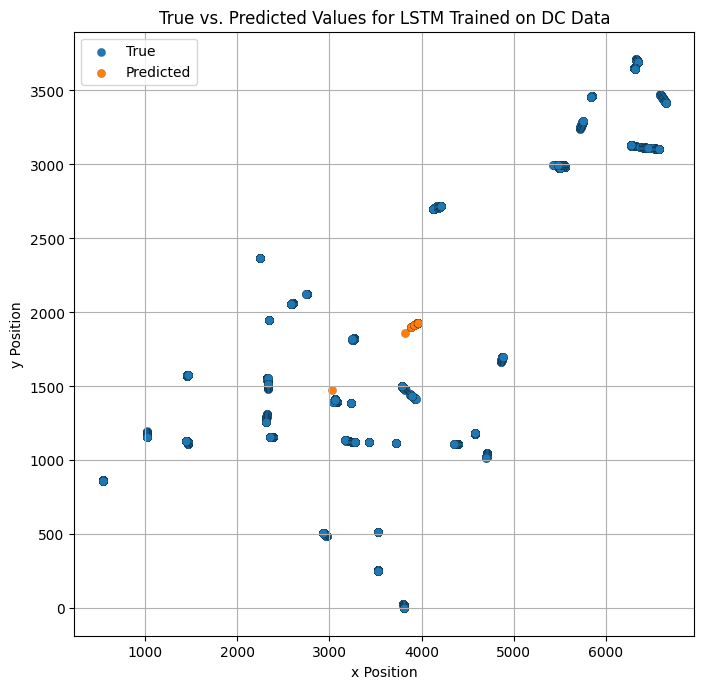

In [423]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_dc[:50,:,0], y_train_dc[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_dc_pred[:50,:,0].detach(), y_train_dc_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on DC Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()

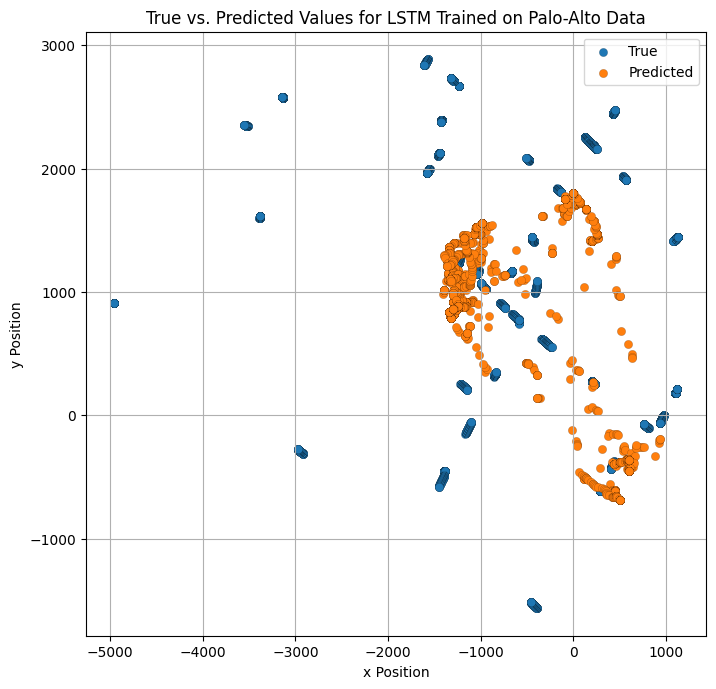

In [424]:
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_palo_alto[:50,:,0], y_train_palo_alto[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_palo_alto_pred[:50,:,0].detach(), y_train_palo_alto_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on Palo-Alto Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()

In [426]:
pd.DataFrame(
    [LSTM_Austin_train_loss, LSTM_Miami_train_loss, LSTM_Pittsburgh_train_loss, LSTM_Dearborn_train_loss, LSTM_DC_train_loss, LSTM_Palo_Alto_train_loss]
).T.rename(columns = {0: "Austin", 1: "Miami", 2: "Pittsburgh", 3: "Dearborn", 4: "DC", 5: "Palo-Alto"})

,Austin,Miami,Pittsburgh,Dearborn,DC,Palo-Alto
0,19921.385725,45149.364107,39544.607162,88676.609141,45373.870859,19960.481358
1,17021.192008,44778.267995,33712.229048,84292.116648,38886.464044,18669.723812
2,18119.989708,42153.816733,27532.436701,84184.489145,32300.125436,18035.875898
3,17608.179734,40642.611241,24883.035856,80078.130092,26693.058220,16293.103438
4,18068.073362,38843.495072,23294.233012,78711.219237,24566.279793,16242.869645
5,18566.749847,39051.298200,22023.153996,78554.387352,21499.407150,14404.884960
6,16745.322980,39768.671755,19974.401471,75872.290895,20510.895000,13991.734109
7,15979.242956,37286.062962,20553.692967,72478.014317,20295.479734,12893.286281
8,15112.489379,35284.140805,20966.109599,67513.240838,19476.806236,12176.754057
9,14898.102149,36013.499077,19439.804357,66468.817680,19833.689253,11879.341035


In [440]:
pd.DataFrame(
    [y_train_austin_RMSE, y_train_miami_RMSE, y_train_pittsburgh_RMSE, y_train_dearborn_RMSE, y_train_dc_RMSE, y_train_palo_alto_RMSE],
    index = ["Austin", "Miami", "Pittsburgh", "Dearborn", "DC", "Palo-Alto"],
    columns = ["Final Train RMSE"]
)

,Final Train RMSE
Austin,1026.162329
Miami,2521.635085
Pittsburgh,1364.359786
Dearborn,3190.568131
DC,1329.188004
Palo-Alto,1082.273648


## 2A.

The model implemented utilizes an input LSTM layer with 100 hidden units followed by a fully connected linear layer. The model is flexible in using variable sequence lengths (input and output k predictions at a time). Example: if the LSTM is initialized with a sequence length of 1, then training the model means taking each combination of k coordinate(s) and using the next observed k coordinate(s) as a target. Shift the window over to use the next k coordinate(s) with the next after k coordinate(s) as the target and repeat until no more data can be observed for the sequence. 

- I used a CPU for training since my machine does not run a Nvidia GPU.
- My optimizer was SSE, but the model was evaluated with the RMSE. Because the input and output corresponded to a single entry in the dataset, it made no sense to calculate the MSE for a single entry but rather divide the SSE afterwards by the batch size to get MSE for the training epoch. Hyperparameters like learning rate / decay, momentum, and other parameters were static because of the difficulties in reliably training a model due to usage of a CPU.
- 60 step predictions for each target agent were made from taking the last known positions and predicting the next 60. Depending on the sequence length, the number of final observed positions varies (taking the last 1 vs. last 10 observed positions).
- The city information had not been utilized (yet) at this stage and instead been aggregated into a single dataset to see if one model could perform better on the entire dataset rather than having separate models for each city's data.
- 100 epochs were used with a batch-size of 25% of a subset of the training data. Epoch runtime increases with sequence length, so one epoch for an LSTM with sequence length 1 generally took about 300s whereas an epoch for an LSTM model with sequence length 10 generally took about 30 seconds. Note that early stopping was implemented by splitting the training data into training and validation sets (80% train / 20% validation), then feeding the validation set into the model's training to compare validation RMSE loss over the iterations. If the validation loss did not improve after 3 iterations, training would stop. Early stopping and stochastic gradient descent with batches helps to prevent overfitting by ensuring that the model can generalize well on an unseen dataset along with randomization helping to simply estimate the optimal solution rather than finding it from the entire dataset. Allowing the model to train for 100 iterations and / or on the entire dataset would result in a lower capacity to generalize well on the validation and test sets.

## 2B.

Linear Regression prediction

In [86]:
from torch import nn, optim

class Lin_Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.lin = nn.Linear(100, 120)
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.lin(x)
        x = x.reshape(-1, 60, 2)
        return x
    
pred = Lin_Pred()
opt = optim.Adam(pred.parameters(), lr=1e-3)

for epoch in range(10):
    
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        preds = pred(inp)
        loss = ((preds - out) ** 2).sum()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
        
    print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))

epoch 0 loss: 1420987.2757404142
epoch 1 loss: 250538.73069174134
epoch 2 loss: 218959.65714901264
epoch 3 loss: 185186.68497620375
epoch 4 loss: 158165.1916673845
epoch 5 loss: 142177.8382814895
epoch 6 loss: 133647.89562838146
epoch 7 loss: 121159.43345017776
epoch 8 loss: 115367.91559199554
epoch 9 loss: 115201.24492793366


MCP Prediction

In [87]:
from torch import nn, optim

class MCP_Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

pred = MCP_Pred()
opt = optim.Adam(pred.parameters(), lr=1e-3)

for epoch in range(10):
    
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        preds = pred(inp)
        loss = ((preds - out) ** 2).sum()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
        
    print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))

epoch 0 loss: 4650459.10658435
epoch 1 loss: 858438.2675639022
epoch 2 loss: 766163.8062241053
epoch 3 loss: 679612.7977948219
epoch 4 loss: 588211.8086659311
epoch 5 loss: 491058.4831301748
epoch 6 loss: 448390.1811835955
epoch 7 loss: 416684.7498046064
epoch 8 loss: 382577.31872508733
epoch 9 loss: 342499.6766709135


While we started with a linear regression model, we were getting really terrible loss of around 100,000 for validation error. We then changed to a more complex multilayer perceptron using a ReLU activation function but actually got worse validation loss probably due to overfitting. Thinking about the nature of our dataset as position over time, we realized the usefulness of a RNN model for this task. We also decided to use LSTM specifically so that we could have long term memory from each cell and mitigate vanishing gradient loss. We also implemented an early stopping algorithm for regularization.

## 3A.
`refer to / include the graphs and tables from above`

So far, I have tried training different LSTM models with sequence length(s) of 1, 2, 5, and 10, and comparing their performance on a minuscule sample of the training data with a validation set on the side. The graphs of decreasing training loss along with the table of final training RMSEs show that the LSTM with sequence length 5 performs the best, as it has the least training loss.

Knowing this, I trained different instances of the LSTM model with sequence length 5: one for each city to see if they could predict data for that one city better than the generalized model. The idea is that if the city specific models perform better overall, then using separate models for predictions of each city should would result in better performance on the test set. So far, the LSTM for Austin performs the best with the least training RMSE compared to the worst performing one, the model for Dearborn, which has nearly 3x the training RMSE as the LSTM for Austin.

I learned that even training a model as simple as a neural network with only two layers can still take a long time to train especially if the dataset is massive. Following up to that, early stopping definitely helps to reduce training time to help mitigate this issue. Using a GPU would definitely open up more possibilities for training with different hyperparameters (hidden state, epochs, batch size, larger training data subsets), as it would reduce training time to allow for quicker results and evaluation.

As mentioned above, using a GPU could help to explore other variations of this model and even help to sustain a more complex model with more layers / units. One key thing that could help with improvement would be to rewrite the model implementation so that when predicting, all observed data is fed through the model to help provide an initial foundation to the predictions for the future path instead of solely relying on the last one or several observations which may not describe any particular trajectory that could help with predictions.

In [ ]:
# final_train, final_valid = make_valid_set(train_inp_all, train_out_all)
# final_train_inp, final_train_out = final_train
# final_valid_inp, final_valid_out = final_valid
# final_LSTM = LSTM(final_train_inp, final_train_out, sequence_length = 5, hidden_size = 100)
# final_LSTM_train_loss, final_LSTM_valid_loss = final_LSTM.train(batch_size = 0.25, valid = final_valid)
# final_test_pred = final_LSTM.predict(test_inp_all, output_length = 60)

In [35]:

LSTM5 = LSTM(X_train_all, y_train_all, sequence_length = 5, hidden_size = 100)
LSTM5.load_state_dict(torch.load("LSTM5.pth"))
test_pred_all = LSTM5.predict(test_inp_all, output_length = 60)

In [37]:
test_pred_all.shape

torch.Size([29843, 12, 5, 2])

In [77]:
df = pd.DataFrame(torch.flatten(test_pred_all, 1, 3).to("cpu").detach().numpy())
df = df.rename(columns=dict(zip(np.arange(120), ["v" + str(i) for i in np.arange(120)])))
idd = ([str(i) + "_austin" for i in np.arange(len(test_city_datasets[0]))] +
      [str(i) + "_miami" for i in np.arange(len(test_city_datasets[1]))] +
      [str(i) + "_pittsburgh" for i in np.arange(len(test_city_datasets[2]))] +
      [str(i) + "_dearborn" for i in np.arange(len(test_city_datasets[3]))] +
      [str(i) + "_washington-dc" for i in np.arange(len(test_city_datasets[4]))] +
      [str(i) + "_palo-alto" for i in np.arange(len(test_city_datasets[5]))])
df.insert(loc=0, column='ID', value=idd)

In [80]:
df.to_csv("out.csv", index=False)

In [ ]:
# LSTM5 = LSTM(X_train_all, y_train_all, sequence_length = 5, hidden_size = 100)
# LSTM5.load_state_dict(torch.load("LSTM5.pth"))
# LSTM5 = LSTM5.cuda()
# test_pred_all = []
# i = 0
# for entry in test_inp_all:
#     with torch.no_grad():
#         pred = LSTM5.predict([entry], output_length = 120)
#     test_pred_all.append(pred.to('cpu'))
#     del pred
#     torch.cuda.empty_cache()
#     if i % 1000 == 0:
#         print(i)
#     i += 1